# Loan Data from Prosper Exploration
## by Jeff Mitchell

## Preliminary Wrangling

This dataset contains information on nearly 114,000 loans from Prosper. The dataset contains a lot of features and will require some wrangling before we can start analysing it.

In [8]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [9]:
loans = pd.read_csv('prosperLoanData.csv')

In [10]:
# high-level overview of data shape and composition
print(loans.shape)
print(loans.dtypes)

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


### What is the structure of your dataset?

There are 113,937 loans with 81 features for each loan. This is a lot of features and some are only relevant to certain periods of time (e.g. pre-2009, post-July 2009). These features include details such as Term, Loan status, Borrower rate, various scores and ratings, demographic features such as Occupation, Employment status, Home ownership, various credit scores and totals, income range and details specific to the loan.

Each loan can be identified by its unique LoanNumber. There are other unique columns such as ListingNumber, ListingKey etc., however, each of these can be related back to the LoanNumber.

### What is/are the main feature(s) of interest in your dataset?

I am most interested in finding out what features have the greatest impact on Loan Outcome Status, specifically on whether or not the loan is paid off.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Features of interest in investigating Loan Outcome Status include the reason for the loan (ListingCategory), their employment status (EmploymentStatus), their credit scores, their monthly income, the amount of the loan (LoanOriginalAmount) and level of monthly payments (MonthlyLoanPayment). Other features that may also be worth investigating include the number of delinquincies, their debt-to-income ratio (DebtToIncomeRatio) and their home ownership status. I expect that borrowers with higher debt-to-income ratios, lower monthly income and lower credit scores are less likely to complete their loan payments.

### Initial cleaning

A quick visual assessment of the raw the data file shows that the data requires some initial cleaning before I can start analysing it. This will involve dropping unnecessary columns, cleaning column types and creating new columns to help with the analysis.

The large number of columns in the data will make analysis difficult. I will start by reducing the dataframe to only the columns that are of interest to me for investigating the Loan Outcome Status. For example, LoanNumber can be used to identify individual loans. This removes the need to hold ListingNumber, ListingKey and LoanKey which are all associated with a unique LoanNumber.

In [11]:
# Reduce the number of columns to just those that may be of interest
columns = ['Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'ListingCategory (numeric)', 'EmploymentStatus', 
           'IsBorrowerHomeowner', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'TotalCreditLinespast7years',
           'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'CurrentDelinquencies', 'DelinquenciesLast7Years', 
           'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanNumber', 'LoanOriginalAmount', 'LoanOriginationQuarter',
           'MemberKey', 'MonthlyLoanPayment']
loans = loans[columns]

Some of the column headings are confusing or difficult to work with so I will rename them.

In [12]:
loans = loans.rename(columns={'ListingCategory (numeric)':'ListingCategory','IsBorrowerHomeowner':'HomeOwner',
                              'TotalCreditLinespast7years':'TotalCreditLines',
                              'DelinquenciesLast7Years':'TotalDelinquencies'})

I am interested in the effect of the features on Loan Outcome Status. Loans that have not yet reached an outcome need to be removed as I do not know what their final outcome will be (I cannot identify what effect their features have on Loan Outcome Status as their status is not yet known). First I will check the values in the LoanStatus column.

In [13]:
loans.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

For this analysis I am going to consider 'Chargedoff' and 'Defaulted' as loans that were not completed successfully. Loans that are 'Past Due...' I will consider current as they still have the potential to be completed. The loans to be removed are those listed as 'Current', 'Past Due...' and 'FinalPaymentInProgress'. 

In [14]:
# Remove loans that have not reached an outcome
loans = loans[loans['LoanStatus'].isin(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'])]
loans.LoanStatus.value_counts()

Completed     38074
Chargedoff    11992
Defaulted      5018
Cancelled         5
Name: LoanStatus, dtype: int64

As I will be using LoanNumber to identify unique loans, I need to make sure there are no duplicated loan records.

In [15]:
dupes = loans[loans['LoanNumber'].duplicated() == True]
dupes

,Term,LoanStatus,BorrowerAPR,BorrowerRate,ListingCategory,EmploymentStatus,HomeOwner,CreditScoreRangeLower,CreditScoreRangeUpper,TotalCreditLines,...,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment
33959,60,Completed,0.28875,0.2624,3,Employed,False,660.0,679.0,61.0,...,255.0,0.0,0.0,0.33,4506.666667,131358,5500,Q1 2014,85D535659273197054A0BB3,165.45
37956,36,Completed,0.22875,0.1915,1,Employed,False,660.0,679.0,19.0,...,459.0,0.0,0.0,0.20,6083.333333,105288,20000,Q4 2013,8EC335867884136891E9E14,734.64
51079,36,Completed,0.23438,0.1970,1,Employed,True,660.0,679.0,43.0,...,1027.0,0.0,0.0,0.16,14583.333333,123094,5000,Q4 2013,9FA83698836314377793393,185.05
60004,36,Completed,0.13799,0.1099,7,Employed,True,680.0,699.0,21.0,...,237.0,0.0,1.0,0.23,4250.000000,110303,2000,Q4 2013,4553358888719707373CD1C,65.47
61289,36,Completed,0.09000,0.0766,1,Self-employed,True,800.0,819.0,17.0,...,178.0,0.0,0.0,NaN,7500.000000,107275,3500,Q4 2013,34193560492599576667729,109.13
68585,36,Completed,0.18633,0.1500,1,Employed,False,700.0,719.0,40.0,...,604.0,0.0,0.0,0.34,7500.000000,121979,15000,Q4 2013,27FA3533700778342A3BB33,519.98
70435,60,Completed,0.19988,0.1760,1,Employed,True,720.0,739.0,26.0,...,159.0,2.0,0.0,0.26,4125.000000,119188,15000,Q4 2013,4FC835464074587007C7ABC,377.64
96475,60,Completed,0.22601,0.2015,1,Employed,False,680.0,699.0,20.0,...,506.0,0.0,0.0,0.23,4125.000000,101908,15000,Q3 2013,7EF83383685864632D111F0,398.66
97137,36,Completed,0.32446,0.2850,1,Employed,False,660.0,679.0,30.0,...,88.0,0.0,13.0,0.17,5833.333333,121751,4000,Q4 2013,4E9335537538907782E9392,166.54
97330,60,Completed,0.23318,0.2085,1,Employed,True,680.0,699.0,26.0,...,339.0,0.0,0.0,0.32,4166.666667,118909,13000,Q4 2013,117636957815160767DC8DC,350.60


There are 13 duplicated records in the data based on LoanNumber. A visual check of these in the raw data showed that the only difference between the duplicates was the ProsperScore, which is not being used in this analysis. For this reason we can drop the duplicate rows, keeping only the first row (default behaviour).

In [16]:
# Drop rows duplicated on LoanNumber
loans.drop_duplicates('LoanNumber', inplace=True)

I am interested in knowing the outcome of the loan - if it was successfully paid off or not. This will be easiest by creating a new column that records the final status of the loan - LoanCompleted - which holds a string, either 'Completed' (paid off) or 'Not completed' (not paid off). This will be set to be a category type.

In [17]:
# Function to return loan completion status
def getLoanCompleted(loan_status):
    """Return 'Completed' if loan completed, 'Not completed' otherwise."""
    if loan_status.strip() == 'Completed':
        return 'Completed'
    else:
        return 'Not completed'
    
# Create column to hold status of loan outcome
loans['LoanCompleted'] = loans['LoanStatus'].apply(getLoanCompleted)
loans['LoanCompleted'] = loans['LoanCompleted'].astype('category')

# Drop LoanStatus column
loans.drop('LoanStatus', axis=1, inplace=True)

In [18]:
# Examine remaining columns
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55076 entries, 0 to 113935
Data columns (total 21 columns):
Term                           55076 non-null int64
BorrowerAPR                    55051 non-null float64
BorrowerRate                   55076 non-null float64
ListingCategory                55076 non-null int64
EmploymentStatus               52821 non-null object
HomeOwner                      55076 non-null bool
CreditScoreRangeLower          54485 non-null float64
CreditScoreRangeUpper          54485 non-null float64
TotalCreditLines               54379 non-null float64
OpenRevolvingAccounts          55076 non-null int64
OpenRevolvingMonthlyPayment    55076 non-null float64
CurrentDelinquencies           54379 non-null float64
TotalDelinquencies             54086 non-null float64
DebtToIncomeRatio              50847 non-null float64
StatedMonthlyIncome            55076 non-null float64
LoanNumber                     55076 non-null int64
LoanOriginalAmount             55076 n

Several of the columns will need some cleaning before we can perform analysis on them. Firstly we can convert the LoanNumber to a string as we are using it as a reference only.

In [19]:
# Convert LoanNumber to a string as we will not perform calcluations on it
loans['LoanNumber'] = loans['LoanNumber'].astype('str')

The ListingCategory column currently only has ints. These will be much easier to analyse by converting them to a string that states what the int represents and then setting the column to category type.

In [20]:
# Convert the ListingCategory column to readable values
def convert_listing_category(cat):
    """Convert the listing category to a human-readable string."""
    categories = ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use',
                 'Auto', 'Other', 'Baby and Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans',
                 'Household Expenses', 'Large Purchases', 'Medical and Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
                 'Wedding']
    return categories[cat]

loans['ListingCategory'] = loans['ListingCategory'].apply(convert_listing_category)

# Convert ListingCategoy to categorical types
loans['ListingCategory'] = loans['ListingCategory'].astype('category')

There are null values in the EmploymentStatus column so let's take a closer look at the column.

In [21]:
loans['EmploymentStatus'].value_counts()

Full-time        24958
Employed         16479
Not available     5347
Self-employed     2925
Part-time         1056
Other              798
Retired            697
Not employed       561
Name: EmploymentStatus, dtype: int64

The null values in EmploymentStatus can also be represented by the existing 'Not available' value, so these should be converted to be consistent and make analysis easier.

In [22]:
# Convert null EmploymentStatus to 'Not available'
loans['EmploymentStatus'] = loans['EmploymentStatus'].fillna('Not available')

The employment status categories are not particularly useful in their current form as it is not clear how to differentiate between the 'Employed' category and 'Full-time', 'Part-time', 'Self-employed' etc. For this analysis I will convert the 'Employed' borrowers to 'Full-time' as it seems reasonable to assume that most employed borrorwers will be employed full-time, given that in the loan data they are 25 times more likely to be employed full-time than part-time. Also, I am interested in identifying if being employed increases the chances of a loan being paid off, so grouping employed borrowers together makes sense.

In [23]:
mask = loans['EmploymentStatus'] == 'Employed'
column_name = 'EmploymentStatus'
loans.loc[mask, column_name] = 'Full-time'

The column can now be converted to a category type which is more appropriate for this data.

In [24]:
# Convert EmploymentStatus to categorical type
loans['EmploymentStatus'] = loans['EmploymentStatus'].astype('category')

LoanOriginationQuarter can also be converted to a category type.

In [25]:
# Convert LoanOriginationQuarter to categorical type
loans['LoanOriginationQuarter'] = loans['LoanOriginationQuarter'].astype('category')

Loan Term may be a candidate for a category type if there are limited term options. Let's see.

In [26]:
loans.Term.value_counts()

36    49852
60     3692
12     1532
Name: Term, dtype: int64

There are only three possible terms, so these are better represented as categories

In [27]:
# Convert Term to categorical type
loans['Term'] = loans['Term'].astype('category')

The Credit Score will be more useful if there is one Credit Score value per loan, rather than a lower and upper value. A new column can be created that holds the mean of the lower and upper scores for each row.

In [28]:
# Function to calculate mean of lower and upper credit ratings
def get_rating(lower, upper):
    "Calculate mean of lower and upper credit ratings."
    mean = (lower + upper) / 2
    return mean

# Add CreditScore column and populate
loans['CreditScore'] = loans.apply(lambda x: get_rating(x['CreditScoreRangeLower'], x['CreditScoreRangeUpper']), axis=1)

# Drop unneeded Credit Range columns
loans.drop(['CreditScoreRangeLower','CreditScoreRangeUpper'], axis=1, inplace=True)

In [29]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55076 entries, 0 to 113935
Data columns (total 20 columns):
Term                           55076 non-null category
BorrowerAPR                    55051 non-null float64
BorrowerRate                   55076 non-null float64
ListingCategory                55076 non-null category
EmploymentStatus               55076 non-null category
HomeOwner                      55076 non-null bool
TotalCreditLines               54379 non-null float64
OpenRevolvingAccounts          55076 non-null int64
OpenRevolvingMonthlyPayment    55076 non-null float64
CurrentDelinquencies           54379 non-null float64
TotalDelinquencies             54086 non-null float64
DebtToIncomeRatio              50847 non-null float64
StatedMonthlyIncome            55076 non-null float64
LoanNumber                     55076 non-null object
LoanOriginalAmount             55076 non-null int64
LoanOriginationQuarter         55076 non-null category
MemberKey                     

### Missing Values

There are several columns that contain missing values. We need to address each of these individually.

There are 25 rows missing the BorrowerAPR. This is a very small percentage of the total so we can use the mean for the column to fill these values.

In [30]:
# Fill missing BorrowerAPR values with the mean for the column
mean_apr = loans.BorrowerAPR.mean()
loans['BorrowerAPR'] = loans.BorrowerAPR.fillna(mean_apr)

There are 591 rows missing Credit Score details. We should check what other information these rows are missing.

In [31]:
missing = loans[loans['CreditScore'].isnull() == True]
missing.head()

,Term,BorrowerAPR,BorrowerRate,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
206,36,0.27767,0.2700,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.16573,9166.666667,323,7500,Q1 2006,110A336465998424756030B,306.19,Not completed,NaN
387,36,0.09337,0.0865,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.12624,3000.000000,174,3500,Q1 2006,69D933646754525905A852D,110.73,Completed,NaN
698,36,0.07680,0.0700,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.02727,8333.333333,36,6001,Q1 2006,8DE133657363264326FD856,185.29,Completed,NaN
1023,36,0.08684,0.0800,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.02480,8333.333333,396,5000,Q2 2006,6D11336601070734709170C,156.68,Completed,NaN
1126,36,0.20735,0.2000,Not Available,Not available,False,NaN,0,0.0,NaN,NaN,0.13759,4250.000000,202,2550,Q1 2006,EDAD3365722336384C605F7,94.77,Completed,NaN


We can see that these rows are missing all of their credit data along with ListingCategory, EmploymentStatus, Delinquincies etc. We can drop these rows from the data as they only represent around 1% of the target data and I do not want to introduce noise or errors by using the mean for these values. ListingCategory, EmploymentStatus and HomeOwner also cannot be adequately filled by a default value so it is best to drop these rows.

In [32]:
# Drop rows missing credit values
loans = loans[loans['CreditScore'].isnull() == False]

The remaining columns that have missing values can be dealt with when they are analysed - the null values can remain in place. Now we can look at an overview of the remaining data of interest.

In [33]:
print(loans.shape)
print(loans.dtypes)
print(loans.head())

(54485, 20)
Term                           category
BorrowerAPR                     float64
BorrowerRate                    float64
ListingCategory                category
EmploymentStatus               category
HomeOwner                          bool
TotalCreditLines                float64
OpenRevolvingAccounts             int64
OpenRevolvingMonthlyPayment     float64
CurrentDelinquencies            float64
TotalDelinquencies              float64
DebtToIncomeRatio               float64
StatedMonthlyIncome             float64
LoanNumber                       object
LoanOriginalAmount                int64
LoanOriginationQuarter         category
MemberKey                        object
MonthlyLoanPayment              float64
LoanCompleted                  category
CreditScore                     float64
dtype: object
   Term  BorrowerAPR  BorrowerRate     ListingCategory EmploymentStatus  \
0    36      0.16516        0.1580       Not Available    Self-employed   
2    36      0.28269    

In [27]:
loans.describe()

,BorrowerAPR,BorrowerRate,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanOriginalAmount,MonthlyLoanPayment,CreditScore
count,54485.000000,54485.000000,54379.000000,54485.000000,54485.000000,54379.000000,54086.000000,50262.000000,54485.000000,54485.000000,54485.000000,54485.000000
mean,0.222646,0.200789,25.274977,6.143104,328.796550,0.906563,4.572385,0.291532,5043.489058,6274.071983,224.260224,681.235340
std,0.088089,0.081165,14.268204,4.508924,450.006566,2.596514,10.690307,0.740366,5713.731383,5225.328950,186.029469,81.917545
min,0.006530,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,9.500000
25%,0.149900,0.135000,15.000000,3.000000,63.000000,0.000000,0.000000,0.130000,2804.166667,2600.000000,98.690000,649.500000
50%,0.214800,0.194900,23.000000,5.000000,186.000000,0.000000,0.000000,0.200000,4166.666667,4500.000000,172.760000,689.500000
75%,0.295250,0.269900,33.000000,8.000000,422.000000,1.000000,4.000000,0.300000,6250.000000,8000.000000,301.030000,729.500000
max,0.423950,0.360000,136.000000,51.000000,14985.000000,83.000000,99.000000,10.010000,618547.833333,35000.000000,2251.510000,889.500000


Looking at the summary of the remaining data we can see a few items of interest that warrant further exploration. Most borrowers have a debt-to-income ratio of between 0.13 and 0.3, however there are sone with high ratios, up to the limit of 10. Do those with a high ratio have a disproportionate number of failures to pay off their loans? Average original loan amounts are a bit over \\$6000 and generally range from \\$2600 to \\$8000. Do low original loan amount values have a higher chance of being paid off? Do high original loan amounts have a lower chance of being paid off? 

We can see that the minimum value for monthly loan payment is \\$0 which does not seem correct. We will need to check that this is accurate. We should look for a relationship between original loan amounts and monthly loan payments, which we would expect to be closely related. The interquartile range for Credit Score is not that great, with the scores centered between 649.5 and 729.5. Do lower scores result in a higher chance that a loan does not get paid off? Does a high score mean a loan is more likely to get paid off?

## Univariate Exploration

I'll start by looking at the main variable of interest - the Loan Outcome Status.

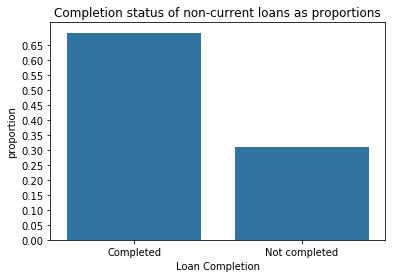

In [34]:
# Plot LoanCompleted column as %
base_color = sb.color_palette()[0]
n_points = loans.shape[0]
max_count = loans['LoanCompleted'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'LoanCompleted', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Loan Completion')
plt.title('Completion status of non-current loans as proportions');

We can see that close to 70% of the loans in the extracted data were completed and 30% were not completed (not paid off). As this is the overall mean for the loans in our remaining sample, we will be interested to see if there a variables, or combinations of vaiables, that result in a completion status that is significantly different from 70%.

I'd like to check the distribution of some of the categorical variables next.

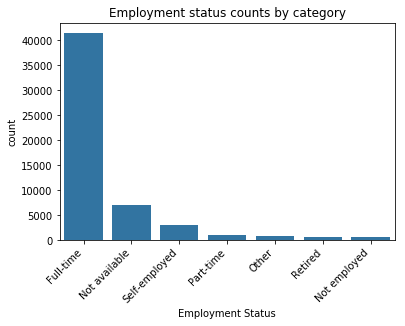

In [35]:
# Plot EmploymentStatus column
cat_order = loans['EmploymentStatus'].value_counts().index
sb.countplot(data = loans, x = 'EmploymentStatus', color = base_color, order=cat_order)
plt.xlabel('Employment Status')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Employment status counts by category');

We can see that most borrowers were involved in some form of employment, however, there was a large proportion for which the employment status was unknown. It will be interesting to see if being employed full-time increases the likelihood of a loan being paid off.

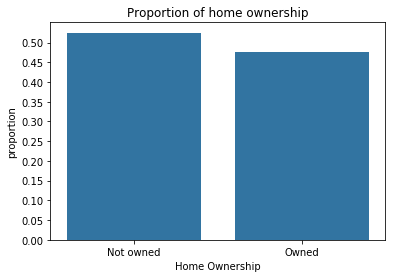

In [36]:
# Plot HomeOwnership column as %
n_points = loans.shape[0]
max_count = loans['HomeOwner'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'HomeOwner', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Home Ownership')
plt.xticks([0, 1], ['Not owned', 'Owned'])
plt.title('Proportion of home ownership');

Home ownership is split pretty evenly across the data with approximately 46% owning their home and the remaining 54% not owning their home.

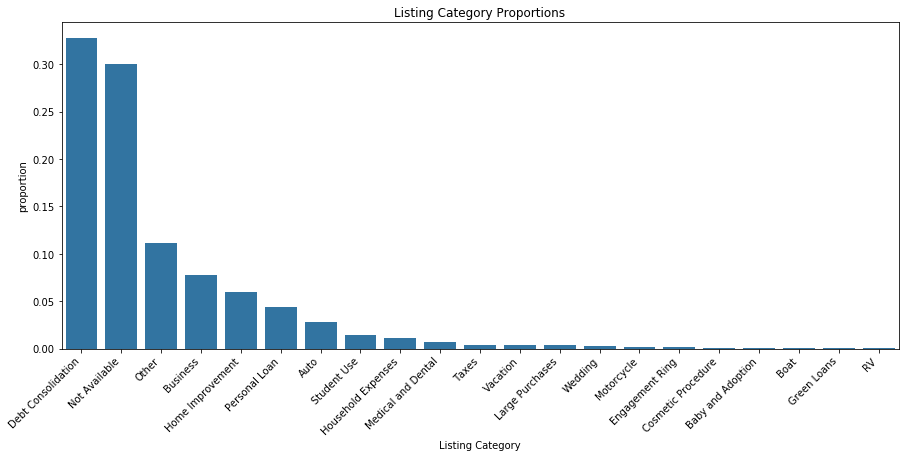

In [37]:
# Plot ListingCategory column as %
plt.figure(figsize=[15,6])
n_points = loans.shape[0]
cat_order = loans['ListingCategory'].value_counts().index
max_count = loans['ListingCategory'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
sb.countplot(data = loans, x = 'ListingCategory', color = base_color, order = cat_order)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Listing Category')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.title('Listing Category Proportions');

Over a third of the Listing Categories fall under 'Debt Consolidation'. Another third is 'Not Available' and a large number are also 'Other' which is not very helpful for analysis. We may be able to look at the effect of the Debt Consolidation category on the outcome of a loan, however, most of the other categories are too underepresented to be able to draw reliable conclusions from.

Let's see if there are any trends in the Quarter the loans originated.

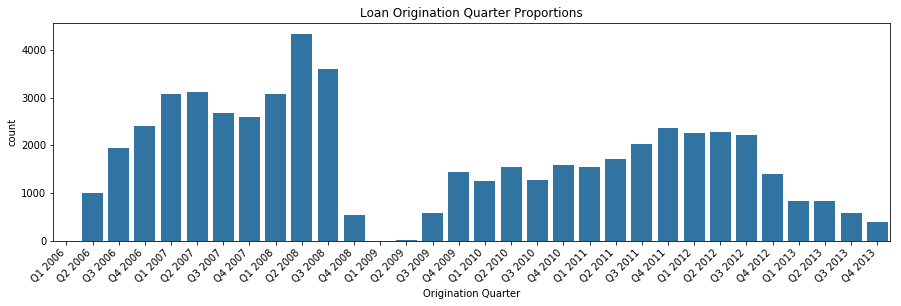

In [38]:
# Plot LoanOriginationQuarter column
plt.figure(figsize=[15,4])
cat_order = ['Q1 2006','Q2 2006','Q3 2006','Q4 2006','Q1 2007','Q2 2007','Q3 2007','Q4 2007','Q1 2008','Q2 2008','Q3 2008',
             'Q4 2008','Q1 2009','Q2 2009','Q3 2009','Q4 2009','Q1 2010','Q2 2010','Q3 2010','Q4 2010','Q1 2011','Q2 2011',
             'Q3 2011','Q4 2011','Q1 2012','Q2 2012','Q3 2012','Q4 2012','Q1 2013','Q2 2013','Q3 2013','Q4 2013']
sb.countplot(data = loans, x = 'LoanOriginationQuarter', color = base_color, order=cat_order)
plt.xlabel('Origination Quarter')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Loan Origination Quarter Proportions');

While there is some variation in the number of loans per quarter, most quarters have between 1200 and 2500 loans. Q4 2008 to Q3 2009 have noticeably fewer loans. I will compare the number of loans in this period with the number in the original dataset to check that the earlier filtering has not skewed the origination quarters in the remaining data.

In [39]:
low_quarters = (loans['LoanOriginationQuarter'] == 'Q4 2008') |\
    (loans['LoanOriginationQuarter'] == 'Q1 2009') | (loans['LoanOriginationQuarter'] == 'Q2 2009') |\
    (loans['LoanOriginationQuarter'] == 'Q3 2009')
low_quarters.sum()

1130

Filtering the original dataset in Excel on the above quarters returned the same number of loans (1130). This means that the low number of loans in these quarters is an aspect of the original dataset and has not been caused by the filtering of the data completed in the data wrangling phase.

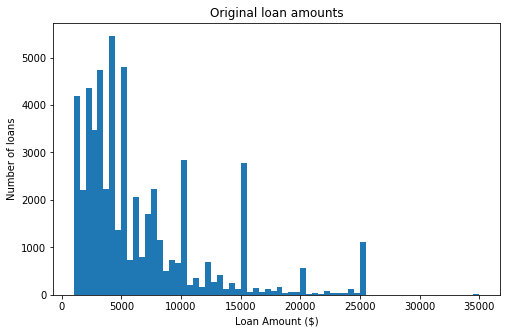

In [40]:
# Plot LoanOriginalAmount column
binsize = 500
bins = np.arange(loans['LoanOriginalAmount'].min(), loans['LoanOriginalAmount'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of loans')
plt.title('Original loan amounts')
plt.show()

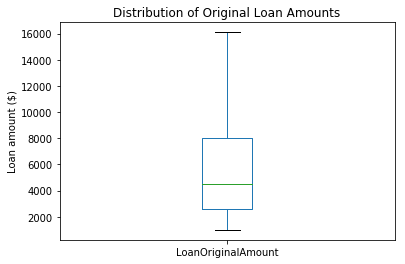

In [41]:
loans['LoanOriginalAmount'].plot(kind='box', showfliers=False)
plt.ylabel('Loan amount ($)')
plt.title('Distribution of Original Loan Amounts');

We can see that the majority of loans are for under \\$6000 although there are spikes at \\$10000, \\$15000, \\$20000 and \\$25000. This is probably due to people taking out loans that round out to a convenient figure (here at \\$5000 intervals). The median is around \\$4500 and most loans fall between \\$2000 and \\$8000.

Due to the long tail we can also plot the Original Loan amounts on a log scale.

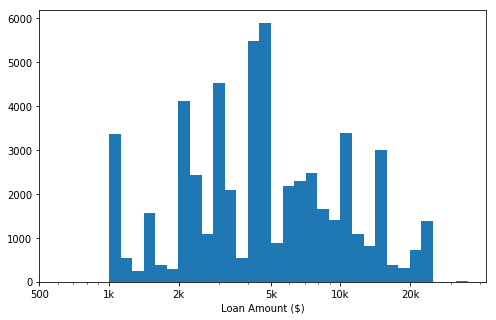

In [42]:
log_binsize = 0.05
bins = 10 ** np.arange(3, np.log10(loans['LoanOriginalAmount'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'LoanOriginalAmount', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Loan Amount ($)')
plt.show()

The Original Loan Amount has a long tail with most of the amounts being below \\$6000 and a few higher amounts, with large spikes at each interval of \\$5000. The log of the Original Loan Amount consists if several large spikes at each $1k log Loan Amount.

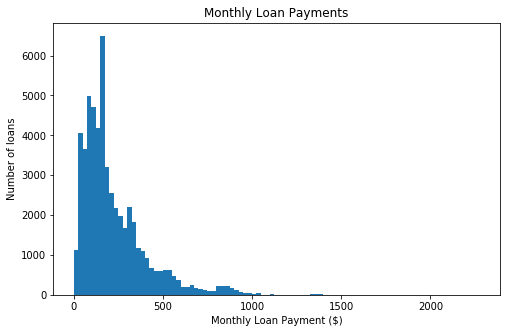

In [43]:
# Plot MonthlyLoanPayment column
binsize = 25
bins = np.arange(0, loans['MonthlyLoanPayment'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'MonthlyLoanPayment', bins = bins)
plt.xlabel('Monthly Loan Payment ($)')
plt.ylabel('Number of loans')
plt.title('Monthly Loan Payments')
plt.show()

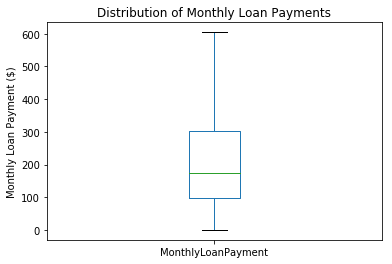

In [44]:
loans['MonthlyLoanPayment'].plot(kind='box', showfliers=False)
plt.ylabel('Monthly Loan Payment ($)')
plt.title('Distribution of Monthly Loan Payments');

We can see with the Monthly Loan Payments that they are also heavily right skewed. There is a spike around \\$200 per month and most payments are below \\$500 per month. Around half of the payments fall between \\$100 and \\$300.

We can plot a log scale of Monthly Loan Payments as it shows a long tail.

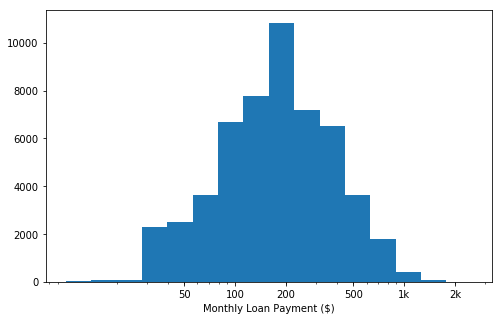

In [45]:
log_binsize = 0.15
bins = 10 ** np.arange(1, np.log10(loans['MonthlyLoanPayment'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'MonthlyLoanPayment', bins = bins)
plt.xscale('log')
plt.xticks([50, 100, 200, 500, 1000, 2000], [50, 100, 200, 500, '1k', '2k'])
plt.xlabel('Monthly Loan Payment ($)')
plt.show()

The Monthly Loan Payment has a long tail with most of the amounts being below \\$500 and a few higher amounts. The log of the Monthly Loan Payment shows a normal distibution with the median monthly payment being a bit under \\$200.

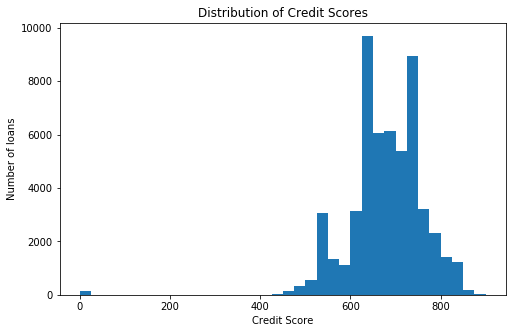

In [46]:
# Plot CreditScore column
binsize = 25
bins = np.arange(0, loans['CreditScore'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'CreditScore', bins = bins)
plt.xlabel('Credit Score')
plt.ylabel('Number of loans')
plt.title('Distribution of Credit Scores')
plt.show()

There are some Credit Scores that are close to 0. These outliers can be removed from the analysis.

In [48]:
# Select borrowers with a credit score of 0
zero_score = loans['CreditScore'] < 50
zero_score.sum()

133

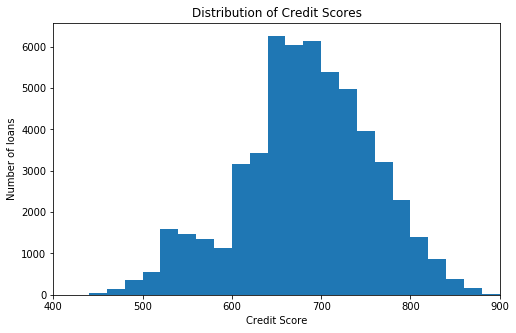

In [49]:
loans = loans.loc[-zero_score,:]

# Plot revised CreditScore column
binsize = 20
bins = np.arange(0, loans['CreditScore'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'CreditScore', bins = bins)
plt.xlabel('Credit Score')
plt.ylabel('Number of loans')
plt.title('Distribution of Credit Scores')
plt.xlim(400,900)
plt.show()

With the outlier credit scores removed we see that at the lower scores the data increases in spikes, levels out around 650 and then drops away fairly consistently to reach its max near 900.

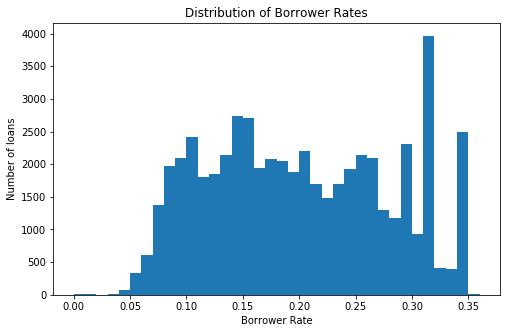

In [51]:
# Plot BorrowerRate column
binsize = 0.01
bins = np.arange(0, loans['BorrowerRate'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'BorrowerRate', bins = bins)
plt.xlabel('Borrower Rate')
plt.ylabel('Number of loans')
plt.title('Distribution of Borrower Rates')
plt.show()

The borrower rates are fairly evenly spread between around 0.08 to 0.3 with two spikes after this at around 3.2 and 3.5.

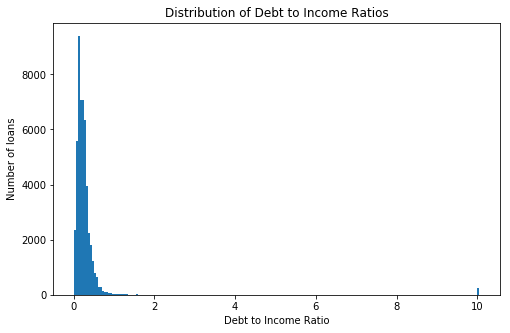

In [52]:
# Plot DebtToIncomeRatio column
binsize = 0.05
bins = np.arange(0, loans['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Number of loans')
plt.title('Distribution of Debt to Income Ratios')
plt.show()

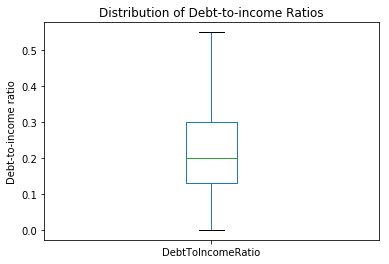

In [53]:
loans['DebtToIncomeRatio'].plot(kind='box', showfliers=False)
plt.ylabel('Debt-to-income ratio')
plt.title('Distribution of Debt-to-income Ratios');

There are a number of outliers above 10 (the highest allowed ratio) which make the graph difficult to read. I will remove these and plot the graph again.

In [55]:
outliers = loans['DebtToIncomeRatio'] > 9.5
outliers.sum()

248

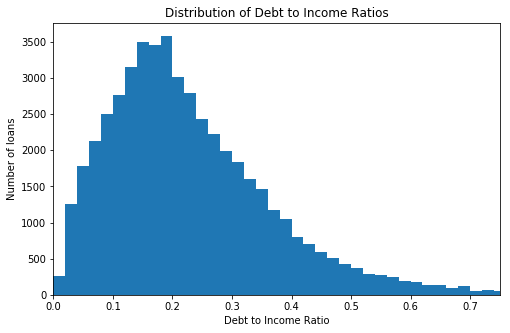

In [61]:
without_outliers = loans.loc[-outliers,:]

# Replot DebtToIncomeRatio column
binsize = 0.02
bins = np.arange(0, without_outliers['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = without_outliers, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Number of loans')
plt.title('Distribution of Debt to Income Ratios')
plt.xlim(0,0.75)
plt.show()

Here we can see that the distribution is skewed to the right with most of the ratios being below 0.5. Most ratios are between 0.1 and 0.3. I will keep the outliers in the loan data as I want to know if these high debt-to-income ratios affect loan outcome.

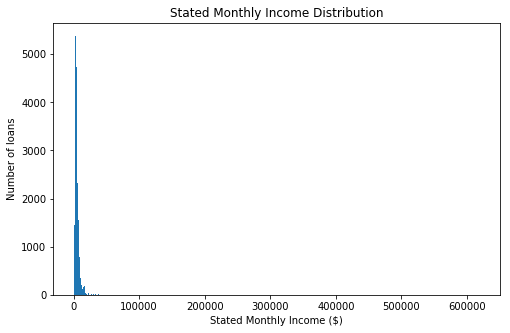

In [57]:
# Plot StatedMonthlyIncome column
binsize = 500
bins = np.arange(0, loans['StatedMonthlyIncome'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Stated Monthly Income ($)')
plt.ylabel('Number of loans')
plt.title('Stated Monthly Income Distribution')
plt.show()

Here we can see again a few outliers have made the graph very difficult to interpret. Let's try removing these outliers.

In [62]:
income_outliers = loans['StatedMonthlyIncome'] > 30000
income_outliers.sum()

141

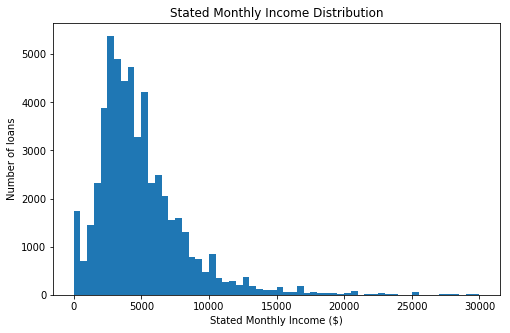

In [63]:
without_outliers = loans.loc[-income_outliers,:]

# Replot the StatedMonthlyIncome graph
binsize = 500
bins = np.arange(0, without_outliers['StatedMonthlyIncome'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = without_outliers, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Stated Monthly Income ($)')
plt.ylabel('Number of loans')
plt.title('Stated Monthly Income Distribution')
plt.show()

The plot now shows a right skew with most of the borrowers earning less than \\$10000 per month. There are a large number of borrowers that do not appear to have any stated income. I want to check if their income is listed as zero or if they are missing other data that suggests that they are missing the income rather than not earning any income.

In [69]:
no_income = loans[loans['StatedMonthlyIncome'] == 0]
no_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 78 to 113803
Data columns (total 20 columns):
Term                           1098 non-null category
BorrowerAPR                    1098 non-null float64
BorrowerRate                   1098 non-null float64
ListingCategory                1098 non-null category
EmploymentStatus               1098 non-null category
HomeOwner                      1098 non-null bool
TotalCreditLines               1094 non-null float64
OpenRevolvingAccounts          1098 non-null int64
OpenRevolvingMonthlyPayment    1098 non-null float64
CurrentDelinquencies           1094 non-null float64
TotalDelinquencies             1092 non-null float64
DebtToIncomeRatio              11 non-null float64
StatedMonthlyIncome            1098 non-null float64
LoanNumber                     1098 non-null object
LoanOriginalAmount             1098 non-null int64
LoanOriginationQuarter         1098 non-null category
MemberKey                      1098 non-null obj

In [70]:
no_income.head(50)

,Term,BorrowerAPR,BorrowerRate,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
78,36,0.18454,0.1700,Business,Full-time,True,26.0,9,962.0,0.0,0.0,NaN,0.0,33852,4800,Q3 2008,D77734052911579724BCDD5,171.13,Not completed,729.5
100,36,0.35356,0.3134,Household Expenses,Not employed,False,10.0,3,56.0,0.0,0.0,NaN,0.0,82947,4000,Q1 2013,CEE83539008163122ED9B62,172.76,Not completed,729.5
108,36,0.28320,0.2600,Debt Consolidation,Full-time,False,21.0,5,198.0,0.0,0.0,NaN,0.0,30830,14000,Q2 2008,34F93419082777341558B78,564.07,Completed,649.5
170,36,0.28851,0.2499,Other,Not employed,True,16.0,6,883.0,0.0,0.0,NaN,0.0,63781,10000,Q2 2012,0B3A35450946276237DF676,397.55,Completed,769.5
186,36,0.35797,0.3177,Home Improvement,Not employed,False,43.0,5,151.0,0.0,83.0,NaN,0.0,60674,4000,Q1 2012,A2603539184865789204203,173.71,Not completed,669.5
332,36,0.25650,0.2375,Not Available,Not available,True,18.0,0,0.0,1.0,NaN,0.10361,0.0,668,1000,Q2 2006,4E95336440121524707AE42,39.10,Not completed,529.5
335,36,0.35797,0.3177,Other,Not employed,False,3.0,2,0.0,0.0,0.0,NaN,0.0,62667,2000,Q1 2012,F1F735415698555052DA0DF,86.85,Completed,769.5
688,36,0.30532,0.2699,Other,Not employed,False,22.0,6,300.0,0.0,0.0,NaN,0.0,51593,2500,Q3 2011,E1583504823481507B7F8A0,102.05,Completed,729.5
772,36,0.10491,0.0980,Debt Consolidation,Full-time,True,25.0,9,448.0,0.0,0.0,NaN,0.0,29671,3500,Q2 2008,33313390658251495A144FE,112.61,Completed,829.5
917,36,0.15713,0.1500,Not Available,Not available,True,17.0,3,296.0,0.0,0.0,NaN,0.0,2552,8000,Q3 2006,4D1333648643890119C04A5,274.24,Completed,729.5


There are 1098 loans that have a stated monthly income of \\$0. Looking at these loans there is no obvious data missing or patterns to the data (e.g. all from specific quarters). The debt-to-income-ratio is missing for most of them, but given that their income is stated as 0 this makes sense. While it is difficult to believe a loan would be given to a borrower with no income, I do not have anything to suggest that these rows are inaccurate so I will keep them in the data.

There appears from the graph of Stated Monthly Income that there are nearly 2000 loans with Stated Monthly Income less than \\$500 so I should check the other low values.

In [88]:
# Find loans below $500 per month of stated monthly income
low_income =  loans[loans['StatedMonthlyIncome'] < 500]
# Remove loans of $0 per month stated monthly income
low_income =  low_income[low_income['StatedMonthlyIncome'] != 0]
low_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 42 to 113626
Data columns (total 20 columns):
Term                           634 non-null category
BorrowerAPR                    634 non-null float64
BorrowerRate                   634 non-null float64
ListingCategory                634 non-null category
EmploymentStatus               634 non-null category
HomeOwner                      634 non-null bool
TotalCreditLines               627 non-null float64
OpenRevolvingAccounts          634 non-null int64
OpenRevolvingMonthlyPayment    634 non-null float64
CurrentDelinquencies           627 non-null float64
TotalDelinquencies             622 non-null float64
DebtToIncomeRatio              564 non-null float64
StatedMonthlyIncome            634 non-null float64
LoanNumber                     634 non-null object
LoanOriginalAmount             634 non-null int64
LoanOriginationQuarter         634 non-null category
MemberKey                      634 non-null object
MonthlyLoanP

In [85]:
low_income.head(50)

,Term,BorrowerAPR,BorrowerRate,ListingCategory,EmploymentStatus,HomeOwner,TotalCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,CurrentDelinquencies,TotalDelinquencies,DebtToIncomeRatio,StatedMonthlyIncome,LoanNumber,LoanOriginalAmount,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LoanCompleted,CreditScore
42,36,0.30300,0.2900,Not Available,Not available,False,20.0,0,0.0,14.0,3.0,0.27,416.666667,7286,1500,Q1 2007,5CCA33798155110380A1C68,62.86,Not completed,529.5
146,36,0.09939,0.0925,Not Available,Not available,False,8.0,3,84.0,0.0,0.0,0.07,0.083333,2902,4000,Q3 2006,862A3365213342789F57EB7,127.66,Completed,749.5
184,36,0.26590,0.2500,Not Available,Not available,False,3.0,2,50.0,1.0,2.0,0.49,200.000000,4846,1200,Q4 2006,9C4B337401069034703BFF6,47.71,Not completed,489.5
226,36,0.11749,0.1000,Not Available,Full-time,True,47.0,23,2866.0,0.0,0.0,10.01,0.083333,8239,1000,Q1 2007,0E243382750780180A98377,32.27,Completed,609.5
576,36,0.10505,0.0935,Not Available,Retired,False,13.0,11,42.0,0.0,0.0,10.01,0.083333,13269,1500,Q2 2007,574C3374106242551D3C75E,47.94,Completed,809.5
895,36,0.35797,0.3177,Household Expenses,Self-employed,True,50.0,23,1306.0,0.0,0.0,NaN,14.583333,59893,4000,Q1 2012,EDCB35372434759063A6711,173.71,Not completed,709.5
1242,36,0.11415,0.1072,Not Available,Not employed,False,12.0,5,165.0,0.0,0.0,10.01,0.083333,16053,3000,Q2 2007,C4C33365996309580AFAC5C,97.82,Completed,749.5
1356,36,0.14982,0.1284,Debt Consolidation,Part-time,False,5.0,1,20.0,1.0,12.0,3.49,48.333333,28751,1450,Q1 2008,085E3414289581697F4FC40,48.74,Completed,529.5
1544,36,0.29205,0.2330,Business,Part-time,False,5.0,1,20.0,0.0,0.0,0.14,416.666667,37539,1000,Q4 2008,F3D3343273718063869EBAE,38.87,Not completed,589.5
1727,36,0.13411,0.1200,Student Use,Part-time,False,4.0,1,25.0,2.0,0.0,0.34,291.666667,29292,2200,Q2 2008,5F343410413133642632886,73.07,Completed,749.5


Again there is no clear pattern to the low income loans that suggests that the data is inaccurate. I can see several Stated Monthly Income values of \\$0.083333 so I will check the value counts on the column to look for anything of interest.

In [89]:
low_income.StatedMonthlyIncome.value_counts()

0.083333      239
416.666667     41
250.000000     19
208.333333     15
166.666667     15
333.333333     12
291.666667     10
458.333333     10
125.000000      9
100.000000      8
200.000000      8
233.333333      7
175.000000      7
400.000000      7
375.000000      6
41.666667       6
83.333333       5
300.000000      5
391.666667      5
433.333333      5
216.666667      4
91.666667       4
141.666667      4
183.333333      4
133.333333      4
4.166667        3
191.666667      3
141.416667      3
116.666667      2
3.750000        2
             ... 
7.083333        1
256.916667      1
113.333333      1
220.666667      1
311.333333      1
148.333333      1
252.916667      1
449.250000      1
388.500000      1
82.416667       1
120.833333      1
140.083333      1
336.583333      1
393.416667      1
483.333333      1
282.500000      1
157.500000      1
374.083333      1
270.833333      1
347.166667      1
124.833333      1
46.916667       1
142.500000      1
1.833333        1
1.416667  

There are 239 borrowers with a Stated Monthly Income of \\$0.083333. This equates to about \\$1 per year which does not seem accurate, especially for someone who is listed as employed. It will be best to remove these loans from the analysis as they cannot be deemed accurate.

In [92]:
# Remove loans where Stated Monthly Income = $0.083333
incorrect_income = loans['StatedMonthlyIncome'] == 0.083333
loans = loans.loc[-incorrect_income,:]

In [93]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54113 entries, 0 to 113935
Data columns (total 20 columns):
Term                           54113 non-null category
BorrowerAPR                    54113 non-null float64
BorrowerRate                   54113 non-null float64
ListingCategory                54113 non-null category
EmploymentStatus               54113 non-null category
HomeOwner                      54113 non-null bool
TotalCreditLines               54070 non-null float64
OpenRevolvingAccounts          54113 non-null int64
OpenRevolvingMonthlyPayment    54113 non-null float64
CurrentDelinquencies           54070 non-null float64
TotalDelinquencies             53785 non-null float64
DebtToIncomeRatio              49960 non-null float64
StatedMonthlyIncome            54113 non-null float64
LoanNumber                     54113 non-null object
LoanOriginalAmount             54113 non-null int64
LoanOriginationQuarter         54113 non-null category
MemberKey                     

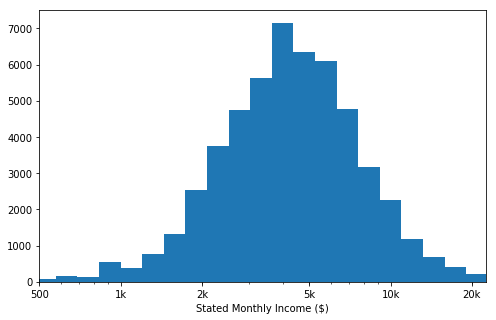

In [94]:
log_binsize = 0.08
bins = 10 ** np.arange(1, np.log10(loans['StatedMonthlyIncome'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'StatedMonthlyIncome', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Stated Monthly Income ($)')
plt.xlim(500, 22500)
plt.show()

With a log transformation the Stated Monthly Income looks normal with the mean being around \\$5000.

We can look at the distribution of the number of loans per borrower by grouping by the MemberKey.

In [95]:
# Create a DataFrame holding the counts of loans per MemberKey
members = loans.groupby('MemberKey').size().reset_index(name='counts')

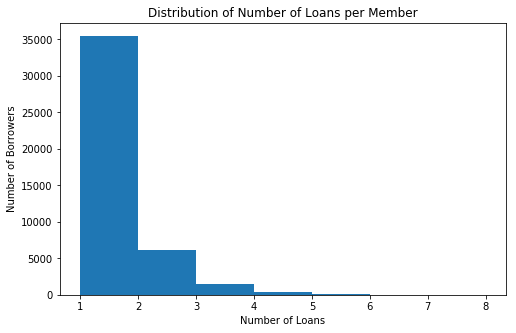

In [106]:
binsize = 1
bins = np.arange(1, members['counts'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = members, x = 'counts', bins = bins)
plt.xlabel('Number of Loans')
plt.ylabel('Number of Borrowers')
plt.title('Distribution of Number of Loans per Member')
plt.show()

We can also look at the proportion of number of loans per borrower.

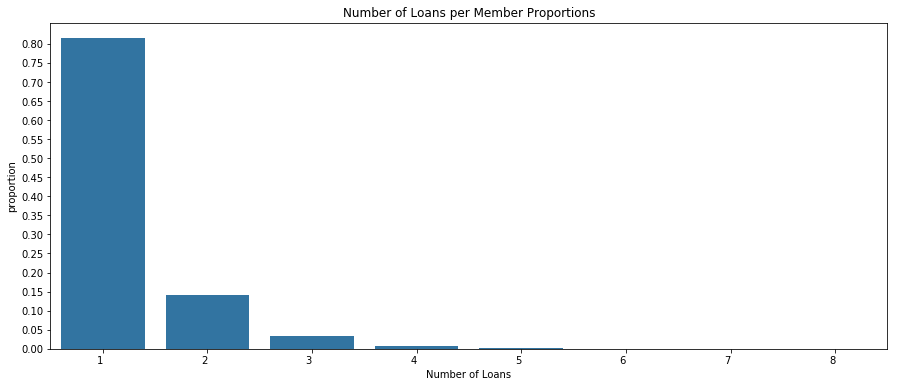

In [102]:
# Plot Loan counts column as %
plt.figure(figsize=[15,6])
n_points = members.shape[0]
cat_order = [1, 2, 3, 4, 5, 6, 7, 8]
max_count = members['counts'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]
ax = sb.countplot(data = members, x = 'counts', color = base_color, order = cat_order)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion')
plt.xlabel('Number of Loans')
plt.xticks(horizontalalignment='right')
plt.title('Number of Loans per Member Proportions')
plt.show();

We can see from this that most (80%) of borrowers have only one finished loan, whether it was completed succesfully or not. A further 14% have two finished loans and around 4% have three. The highest number of finished loans is 8.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

70% of the loans were completed succesfully and 30% were not. Home ownership was split fairly evenly and most borrowers had one completed loan (80%) with 15% with 2 completed loans and around 4% with three. The original loan amounts were skewed to the right and tended to cluster around \\$5000 intervals suggesting that borrowers would take out a loan that was an interval of \\$5000. Monthly loan payments were also skewed to the right, however, after a log transformation these showed a normal distribution. Most monthly payments were below \\$500 with the average being around \\$200.

The Debt-to-income ratios were clearly right skewed with most being below 0.5. Listing Categories had a large number of Unknown and Other listings which make the feature less useful for analysis. Over a third were listed as Debt Consolidation so there is the possibility to look at the effect of Debt Consolidation on Loan Outcome Status compared to the other Listing Categories.

There was variation in the Loan Quarter Originations and a noticeable lack of loans generated between Q4 2008 and Q4 2009. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Some work was required to tidy the data. As I am investingating the impact of featurs on Loan Outcome Status, I needed to remove loans which had not yet reached an outcome (paid off or not paid off). I chose to include Defaulted loans in the not paid off category as there were a large number of them and they are loans that Prosper consider to be unlikely to be paid off. Loans that were past due were removed as I still considered these as current as there was a reasonable chance they may be paid off, as opposed to the defaulted loans.

There were a few loans that were duplicated in the data. The only difference between duplicated loans was the value in the ProsperScore column. I am not going to use this column in my analysis so it is safe to remove duplicates and keep only the first (the default action) as this will not affect my analysis in any way.

The EmploymentStatus column was not very helpful as it contained a large number of 'Employed' results, but then had separate levels of employment in the data also. I addressed this by converting 'Employed' members to 'Full-time' due to the fact that most employed members were in the 'Full-time' category.

There were outliers at the low end for Credit Score which I removed to make the plots clearer. Each of these had a low score of 0 and an upper socre of 19, which may reflect errors in the data. There were also outliers at the high end for StatedMonthlyIncome. I removed those that were above \\$30000 per month from the analysis to make the plots clearer. It is also reasonable to expect that some of these high values were inaccurate when considering the relatively small loan amounts they were for.

Several columns were converted to category types as these were appropriate to the form of the data (each contained clear categories). There were several entries that were missing data for a number of columns so I removed these. A small number of rows were missing the BorrowerAPR so replaced these with the mean for the column, as it was a very small percentage of rows that it was missing from.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

I'll start by looking at the pairwise correlations present between features in the data.

In [76]:
numeric_vars = ['BorrowerAPR', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanOriginalAmount', 'MonthlyLoanPayment',
                'CreditScore']
categoric_vars = ['Term', 'ListingCategory', 'EmploymentStatus', 'LoanOriginationQuarter', 'LoanCompleted']

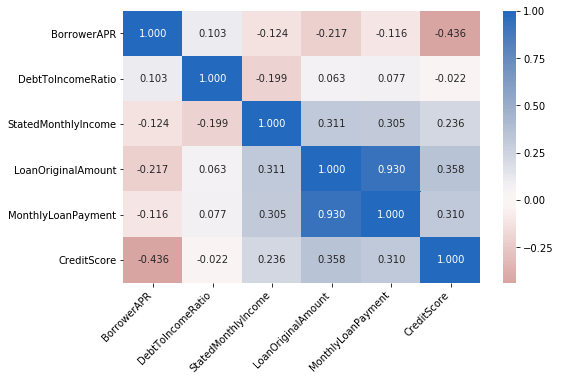

In [77]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(loans[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.xticks(rotation = 45, horizontalalignment='right')
plt.show()

C:\Users\Jeff\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\Jeff\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jeff\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


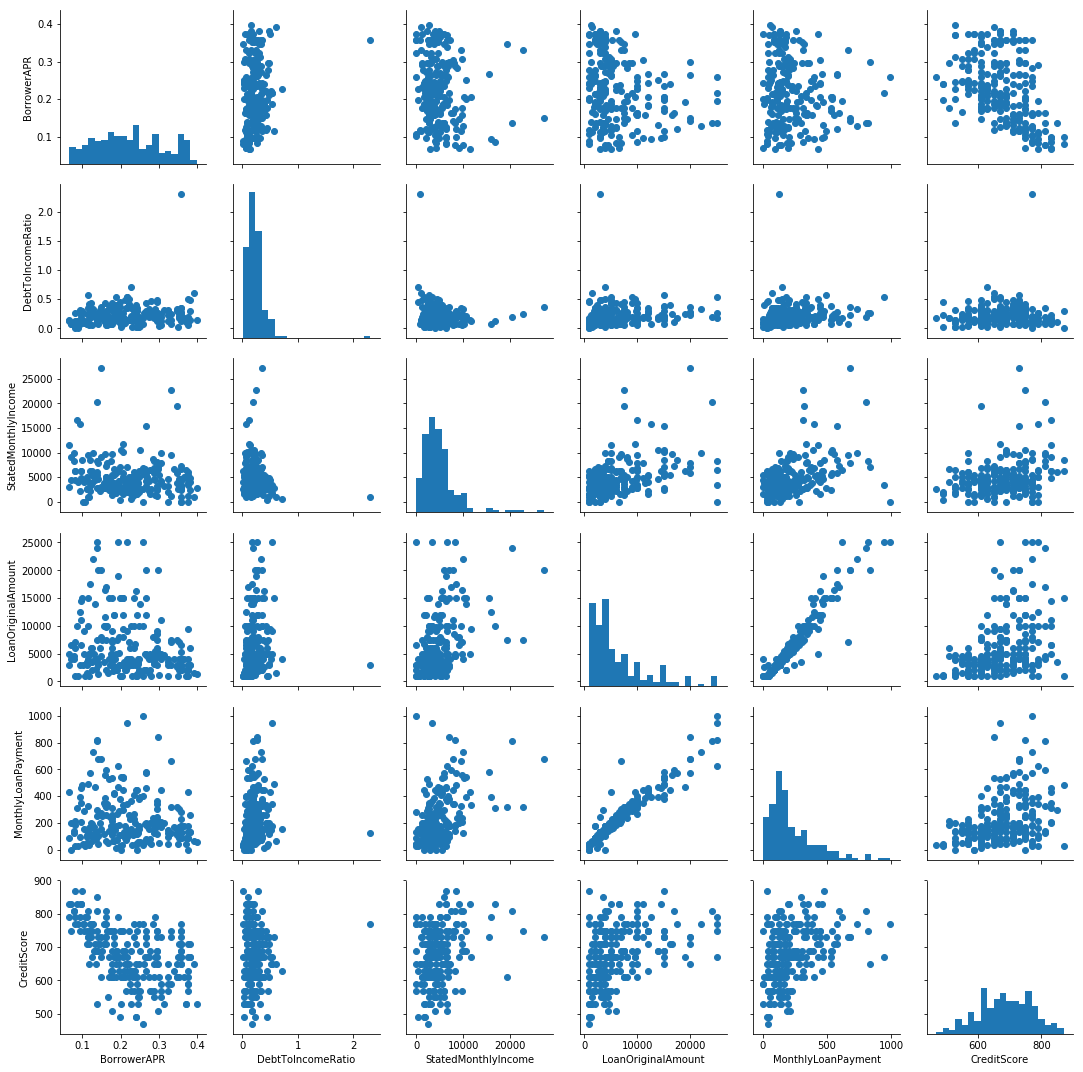

In [57]:
# plot matrix: sample 500 loans so that plots are clearer and they render faster
samples = np.random.choice(loans.shape[0], 500, replace = False)
loans_samp = loans.loc[samples,:]

g = sb.PairGrid(data = loans_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)

The correlations are largely what we would expect for this data:

- BorrowerAPR correlates closest with CreditScore (lower credit score = higher borrower APR)
- Monthly loan payments increase as the Loan Original Amount increases

The correlation scores between the other numeric variables were not high enough to suggest a correlation. Debt-to-income ratios showed the least correlation to any other numeric variable. There does not appear to be any intersting relationships between the numeric variables worth examining further - the only clear relationship is between Loan Original Amount and Monthly Loan Payment which we would expect to be correlated.

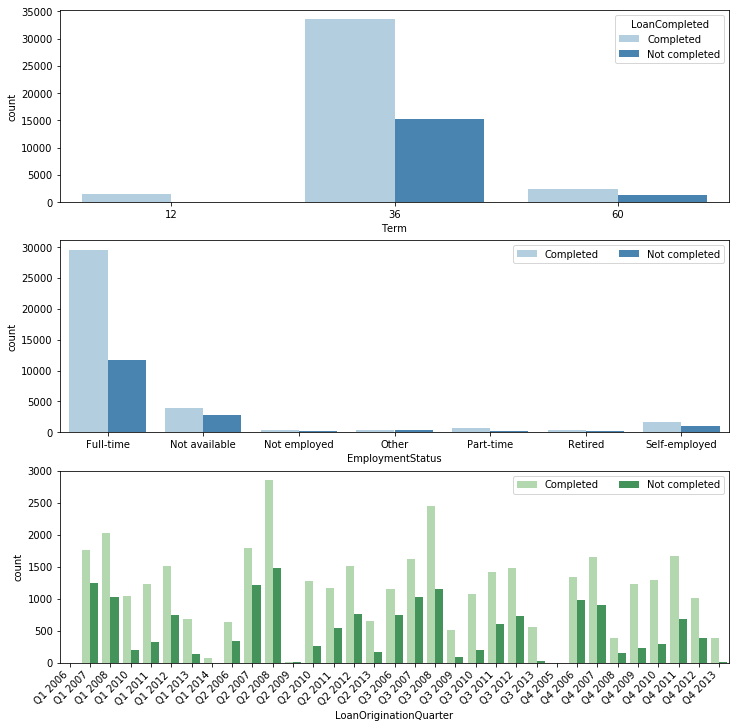

In [58]:
# Plot LoanCompleted against categorical variables
plt.figure(figsize = [12, 12])

# subplot 1: Term vs LoanCompleted
plt.subplot(3, 1, 1)
sb.countplot(data = loans, x = 'Term', hue = 'LoanCompleted', palette = 'Blues')

# subplot 2: EmploymentStatus vs. LoanCompleted
ax = plt.subplot(3, 1, 2)
sb.countplot(data = loans, x = 'EmploymentStatus', hue = 'LoanCompleted', palette = 'Blues')
ax.legend(ncol = 2) # re-arrange legend to reduce overlapping

# subplot 3: ListingOrigniationQuarter vs. LoanCompleted, use different color palette
ax = plt.subplot(3, 1, 3)
sb.countplot(data = loans, x = 'LoanOriginationQuarter', hue = 'LoanCompleted', palette = 'Greens')
plt.xticks(rotation = 45, horizontalalignment='right')
ax.legend(loc = 1, ncol = 2) # re-arrange legend to remove overlapping

plt.show()

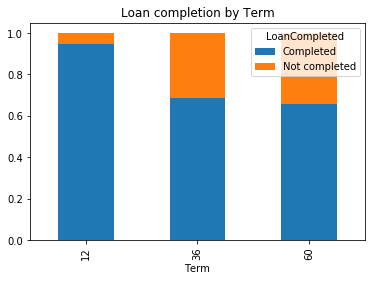

In [59]:
term_props = loans.groupby('Term')['LoanCompleted'].value_counts(normalize=True).unstack()
term_props.plot(kind='bar', stacked='True', title='Loan completion by Term');

In [60]:
term_props

LoanCompleted,Completed,Not completed
Term,,
12,0.946159,0.053841
36,0.687386,0.312614
60,0.655698,0.344302


We can see here that loans with a twelve month term are mostly completed (95%). Loans over 36 and 60 months have a much lower completion rate (69% and 66% respectively).

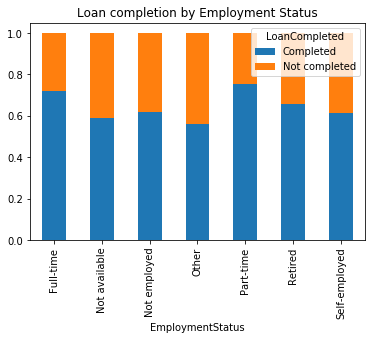

In [61]:
# Compare Loan Outcome Status and Employment
employment_props = loans.groupby('EmploymentStatus')['LoanCompleted'].value_counts(normalize=True).unstack()
employment_props.plot(kind='bar', stacked='True', title='Loan completion by Employment Status');

In [62]:
employment_props.sort_values('Completed', ascending=False)

LoanCompleted,Completed,Not completed
EmploymentStatus,,
Part-time,0.751684,0.248316
Full-time,0.717589,0.282411
Retired,0.658466,0.341534
Not employed,0.619850,0.380150
Self-employed,0.611150,0.388850
Not available,0.590116,0.409884
Other,0.561713,0.438287


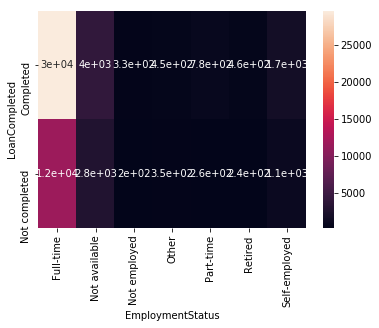

In [81]:
# Create a heat map of employment status and Loan Completion
# NOTE: Try to get proportions instead of counts
ct_counts = loans.groupby(['EmploymentStatus', 'LoanCompleted']).size()
ct_counts = ct_counts.reset_index(name='count')
ct_counts = ct_counts.pivot(index='LoanCompleted', columns='EmploymentStatus', values='count')
sb.heatmap(ct_counts, annot=True);

Borrowers who are employed (either part- or full-time) are the most likely to complete their loan (75% and 72% respectively) while those for whom employment status is not available (Not available and Other) are the least likely to pay the loan, at 59% and 56% repectively.

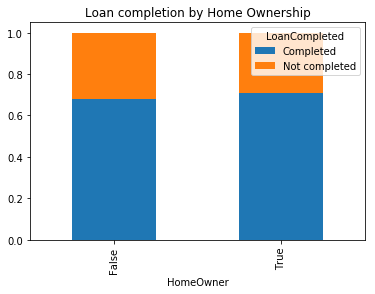

In [63]:
# Compare Loan Outcome Status and Home Ownership
# See if can plot several categorical variables in one set to look for ones that are interesting
home_props = loans.groupby('HomeOwner')['LoanCompleted'].value_counts(normalize=True).unstack()
home_props.plot(kind='bar', stacked='True', title='Loan completion by Home Ownership');

In [64]:
home_props

LoanCompleted,Completed,Not completed
HomeOwner,,
False,0.679121,0.320879
True,0.707334,0.292666


There is only a 3% difference in the rate of loan completion between home owners and non-owners, much smaller than the difference for employed versus non-employed or 12 month terms and 36 or 60 month terms.

In [65]:
# Function to place Debt-To-Income-Ratio into bins
def get_ratio(debt_to_income):
    """Get bin for debt-to-income ratio."""
    if debt_to_income < 0.05:
        return 0.05
    elif debt_to_income < 0.1:
        return 0.1
    elif debt_to_income < 0.15:
        return 0.15
    elif debt_to_income < 0.2:
        return 0.2
    elif debt_to_income < 0.25:
        return 0.25
    elif debt_to_income < 0.3:
        return 0.3
    elif debt_to_income < 0.4:
        return 0.4
    elif debt_to_income < 0.5:
        return 0.5
    elif debt_to_income < 0.6:
        return 0.6
    elif debt_to_income < 0.7:
        return 0.7
    elif debt_to_income < 0.8:
        return 0.8
    elif debt_to_income <0.9:
        return 0.9
    elif debt_to_income < 1:
        return 1
    elif debt_to_income < 3:
        return 3
    elif debt_to_income < 6:
        return 6
    else:
        return 10
    
# Create a column placing Debt-to-income-ratio into a bin
loans['DebtRatioBin'] = loans.DebtToIncomeRatio.apply(get_ratio)

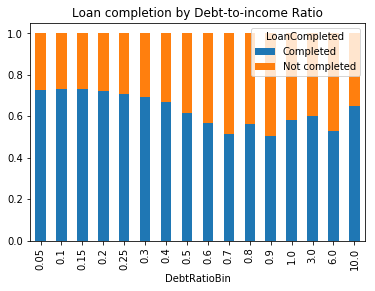

In [66]:
# Compare Loan Outcome Status and Debt Consolidation
debt_props = loans.groupby('DebtRatioBin')['LoanCompleted'].value_counts(normalize=True).unstack()
debt_props.plot(kind='bar', stacked='True', title='Loan completion by Debt-to-income Ratio');

In [67]:
debt_props

LoanCompleted,Completed,Not completed
DebtRatioBin,,
0.05,0.727430,0.272570
0.10,0.732514,0.267486
0.15,0.730634,0.269366
0.20,0.721392,0.278608
0.25,0.707867,0.292133
0.30,0.694733,0.305267
0.40,0.670550,0.329450
0.50,0.617056,0.382944
0.60,0.569444,0.430556


Loan completion rates are fairly consistent between 0 and 0.25 where they are around 72%. From 0.3 onwards they begin to trend down with a slight increase at 0.8 and again at 3 and 10.

In [68]:
# Compare Loan Outcome Status and Loan Origination Quarter
# Could use a heatmap and also look at impact of counts per Quarter (check if should be multivariate analysis)
#NOTE: Need to drop unused categories before running
# quarter_props = loans.groupby('LoanOriginationQuarter')['LoanCompleted'].value_counts(normalize=True).unstack()
# quarter_props.plot(kind='bar', stacked='True', title='Loan completion by Loan Origination Quarter')

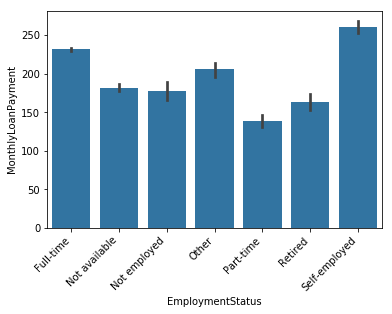

In [86]:
# Compare Employment Status and Monthly Loan Payment
base_color = sb.color_palette()[0]
sb.barplot(data = loans, x = 'EmploymentStatus', y='MonthlyLoanPayment',color=base_color)
plt.xticks(rotation=45, horizontalalignment='right');

The highest monthly payments on average were made to people that were self-employed or working full time. Lower monthly payments on average were made to borrowers that were not employed, retired or employed part-time. This would likely be a reflection of the ability of the borrower to pay back the loan given their monthly income.

Due to the close correlation between Loan Original Amount and Monthly Loan Payments, we only need to analyse one of these. We can look at the effect of Monthly Loan Payments.

In [70]:
# Compare Loan Outcome Status and Monthly Loan Payments
# May need a log transformation on the Monthly Loan Payment

In [71]:
# Compare Loan Outcome Status and Credit Scores

In [72]:
# Compare Loan Outcome Status and BorrowerAPR

In [73]:
# Compare Loan Outcome Status and Stated Monthly Income

In [74]:
# Compare Loan Outcome Status and Number of loans

In [75]:
# DRILL DOWN
# Look at interesting variables and look for relationships between them e.g. Loan amount and Stated Monthly Income

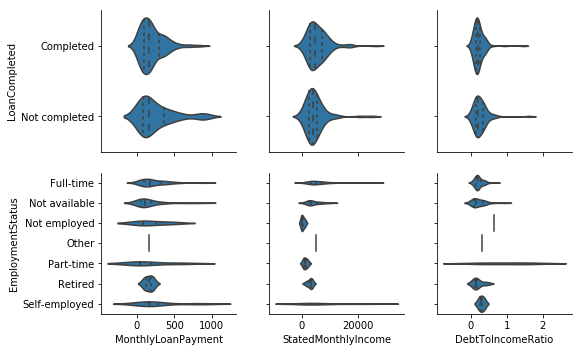

In [85]:
samples = np.random.choice(loans.shape[0], 500, replace = False)
loan_samples = loans.loc[samples,:]

g = sb.PairGrid(data=loan_samples, x_vars = ['MonthlyLoanPayment', 'StatedMonthlyIncome', 'DebtToIncomeRatio'],
               y_vars=['LoanCompleted', 'EmploymentStatus'])
g.map(sb.violinplot, inner = 'quartile');

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

There were not many correlations between the different numeric variables. The only ones that were correlated were as expected - the Monthly Loan Payments are correlated with the total amount of the loan.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In [ ]:
# Plot MonthlyLoanPayment, EmploymentStatus and StatedMonthlyIncome

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!